In [1]:
import numpy as np
import porepy as pp
import scipy.sparse as sps
import math 
import sys
sys.path.append("../class")
from Flow_class import Flow
from Transport_class import Transport
from Reaction_class import Reaction

In [2]:
Nx=30
Ny=30

In [3]:
#gb= pp.grid_buckets_2d.single_vertical([Nx, Ny], y_endpoints=[0.6, 0.2], simplex=False)
#gb, domain = pp.grid_buckets_2d.single_horizontal([Nx, Ny], x_endpoints=[0.2, 0.8], simplex=False)
#print(domain)
#pp.plot_grid(gb,figsize=[15,12])
#domain={'xmin': 0, 'xmax': 1, 'ymin': 0, 'ymax': 1}




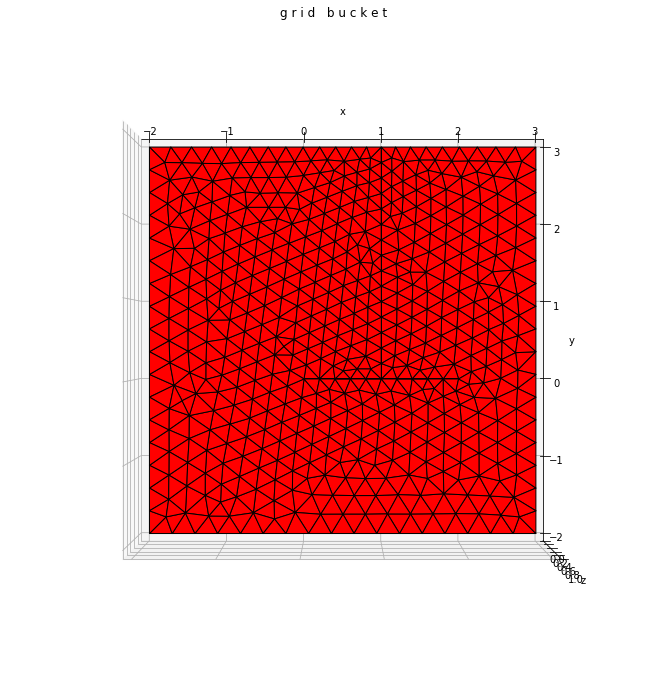

In [4]:
# Point coordinates, as a 2xn array
p = np.array([[0, 2, 1, 1], [0, 0, 0, 3]])
# Point connections as a 2 x num_frac arary
e = np.array([[0, 2], [1, 3]])

# The domain contains two fractures: The first from (0, 0) - (2,0), the second (1, 0) to (1, 1)
# Set domain boundaries
domain = {'xmin': -2, 'xmax': 3, 'ymin': -2, 'ymax': 3}

# Define a fracture network in 2d
network_2d = pp.FractureNetwork2d(p, e, domain)

# Set preferred mesh size close to the fracture, and at the boundary (essentially this is a far-field value)
mesh_args = {'mesh_size_frac': 0.2, 'mesh_size_bound': 0.3}

# Generate a mixed-dimensional mesh
gb = network_2d.mesh(mesh_args)
pp.plot_grid(gb,figsize=(15,12))

In [5]:
print(gb.edges)

<bound method GridBucket.edges of Grid bucket containing 4 grids and 4 interfaces
Maximum dimension present: 2 
Minimum dimension present: 0 
1 grids of dimension 2 with in total 1011 cells
2 grids of dimension 1 with in total 25 cells
1 grids of dimension 0 with in total 1 cells
2 interfaces between grids of dimension 2 and 1 with in total 50 mortar cells
2 interfaces between grids of dimension 1 and 0 with in total 3 mortar cells
>


In [6]:
parameter={"aperture":1e-3,
          "fracture_perm":0.00001,
          #"fracture_perm_2":1e5,
           #"fracture_perm":1e5,
          #"fracture_perm":0.001,
          "perm":1,
          #"f_lambda":lambda x,y,z:math.pi*math.pi*2*math.sin(math.pi*x)*math.sin(math.pi*y),
          "f_lambda":lambda x,y,z:0.0,
          "bc_value":[1000.0,0.0],
          "bc_type":['dir','dir'],
          "method":"Tpfa"}

In [7]:
flow=Flow(gb,domain,parameter)
#flow.add_data()
flow.set_data()
flow.discretize()
flow.solve()
flow.plot_pressure()

KeyError: 'fracture_perm_1'

In [ ]:
parameter={
    "aperture":1e-4,
    "por":0.2,
    "por_frac":0.8,
    #"time_step":1 / 60,
    #"time_step":34.56,
    "time_step":0.001,
    #"t_max":1 /3,
    #"t_max":345600,
    "t_max":0.1,
    "initial_cond":lambda x,y,z:0.0}

transport=Transport(gb,domain,parameter)

In [ ]:
Ca_value=[1.0,0.0]
Ca_type=['dir','dir']
Ca="Ca"

In [ ]:
transport.set_data(Ca_value,Ca_type,Ca)
transport.get_flux(Ca)
transport.discretize(Ca)
lhs_Ca,rhs_source_adv_Ca,rhs_mass_Ca,assembler_Ca=transport.get_transport_lhs_rhs(Ca)


In [ ]:
for g,d in gb:
    print(d[pp.PARAMETERS]["Ca"]["darcy_flux"])

In [ ]:
## to export the flux
key='Ca'
flux='darcy_flux'
mortar='mortar_flux'
flux_P0="P0_flux"

discr_P0_flux = pp.MVEM(key)
for g, d in gb:
    discr_P0_flux.discretize(g, d)
    d[pp.STATE][flux] = d[pp.PARAMETERS][key][flux]

## construct the P0 flux reconstruction
pp.project_flux(gb, discr_P0_flux, flux, flux_P0, mortar)

for g,d in gb:
    print("P0_flux")
    print(d[pp.STATE]["P0_flux"])

for g,d in gb:
    print("pressure")
    print(d[pp.STATE]["pressure"])
    
for g,d in gb:
    d[pp.STATE]["P0_flux"]*=0.005
pp.plot_grid(gb,"pressure","P0_flux",figsize=(15,12))

In [ ]:
save_every = 1
n_steps = int(np.round(parameter["t_max"] / parameter["time_step"]))

# Initial condition
tracer1 = np.zeros(rhs_source_adv_Ca.size)
assembler_Ca.distribute_variable(
    tracer1, variable_names=[Ca,transport.mortar_variable]
)


# Exporter
exporter1 = pp.Exporter(gb, file_name="Ca", folder_name="Ca")
export_field1 = ["Ca"]
IEsolver_Ca = sps.linalg.factorized(lhs_Ca)

In [ ]:
for i in range(n_steps):
    if np.isclose(i % save_every, 0):
        # Export existing solution (final export is taken care of below)
        assembler_Ca.distribute_variable(
        tracer1,
        variable_names=[Ca,transport.mortar_variable],
    )
        exporter1.write_vtu(export_field1, time_step=int(i // save_every))
    tracer1 = IEsolver_Ca(rhs_mass_Ca * tracer1 + rhs_source_adv_Ca)
    for g,d in gb:
        print("Ca")
        print(d[pp.STATE]["Ca"])
    print("FINE")
    
    
exporter1.write_vtu(export_field1, time_step=(n_steps // save_every))
time_steps = np.arange(
    0, parameter["t_max"] + parameter["time_step"], save_every * parameter["time_step"]
)
    
exporter1.write_pvd(time_steps)
transport.plot_tracer(Ca)
